# Hyperoptimization

## Import section

In [1]:
import sys
import os
from functools import partial

import pandas as pd
from ray.tune import CLIReporter, JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.hyperopt import HyperOptSearch

sys.path.append("../../")

from ptgnn.runtime_config.config_helpers import run_config_adapter, load_and_merge_default_configs
from ptgnn.runtime_config.config import import_as, export_as

In [2]:
from ray import tune, train
import os

## Load default config

In [3]:
# fetching config file
benchmark_config = import_as("configs/hyper_param_opt/benchmark_instructions_bindingaffinity_chienn_rwse.yaml")
display(benchmark_config)

{'output_dir': 'results/ba_chienn',
 'config_files': ['configs/hyper_param_opt/subsetting.yaml',
  'configs/add_rwse.yaml',
  'configs/datasets/binding_affinity.yaml',
  'configs/models/chienn.yaml',
  'configs/general.yaml'],
 'search_space': {'model': {'hidden_dimension': 'tune.choice([64, 128, 256])',
   'modules': {1: {'times': 'tune.choice([3, 6, 10])',
     'parameter': {'dropout': 'tune.choice([0.0, 0.2, 0.5])'}}}},
  'optimizer': {'base_learning_rate': 'tune.choice([0.001, 0.0001, 0.00001])'}},
 'hyper_settings': {'scheduler': {'grace_period': 5,
   'reduction_factor': 3,
   'brackets': 1},
  'max_concurrent_trials': 5,
  'num_samples': 50}}

In [4]:
default_config = load_and_merge_default_configs(
    benchmark_config['config_files']
)
display(default_config)

{'data': {'subset_size': 10000,
  'loader': {'general': {'precompute_pos_enc': ['RWSE'],
    'n_neighbors_in_circle': 3,
    'batch_size': 32,
    'num_workers': 0},
   'train': {'sampler': 'full_batch'},
   'val': {'sampler': 'full_batch'},
   'test': {'sampler': 'full_batch'}},
  'dataset': {'type': 'ba',
   'mask_chiral_tasks': True,
   'single_conformer': True,
   'single_enantiomer': False}},
 'model': {'modules': {0: {'parameter': {'node_type': 'linear+RWSE',
     'rwse_params': {'dim_pos_enc': 28, 'norm_type': 'batchnorm'},
     'edge_type': 'linear'},
    'type': 'graph_embedding'},
   1: {'type': 'gps_layer',
    'parameter': {'local_model': 'chienn', 'local_model_params': {}},
    'times': 5}},
  'out_dim': 1,
  'mode': 'custom',
  'hidden_dim': 128,
  'head': {'type': 'san_head', 'n_layer': 3, 'pool_function': 'add'}},
 'training': {'loss_function': 'l1',
  'optimization_metric': 'mae',
  'optimization_metric_mode': 'min',
  'task_type': 'regression',
  'n_max_epochs': 100,


In [5]:
# create absolute path to root dict that is not hyper-opt-run specific
default_config['data']['dataset']['root'] = os.path.abspath(
    os.path.join("src", default_config['data']['dataset']['type'])
)

In [6]:
# currently limit number of epochs
default_config['training']['n_max_epochs'] = 3

In [7]:
display(default_config)

{'data': {'subset_size': 10000,
  'dataset': {'type': 'ba',
   'mask_chiral_tasks': True,
   'single_conformer': True,
   'single_enantiomer': False,
   'root': 'D:\\DATEN\\Masterarbeit_PTGNN\\notebooks\\hyperoptimization\\src\\ba'},
  'loader': {'general': {'n_neighbors_in_circle': 3,
    'batch_size': 32,
    'num_workers': 0},
   'train': {'sampler': 'full_batch'},
   'val': {'sampler': 'full_batch'},
   'test': {'sampler': 'full_batch'}}},
 'training': {'loss_function': 'l1',
  'optimization_metric': 'mae',
  'optimization_metric_mode': 'min',
  'task_type': 'regression',
  'n_max_epochs': 3,
  'clip_grad_norm': True},
 'model': {'out_dim': 1,
  'mode': 'custom',
  'hidden_dim': 128,
  'modules': {0: {'type': 'graph_embedding',
    'parameter': {'node_type': 'linear', 'edge_type': 'linear'}},
   1: {'type': 'gps_layer',
    'parameter': {'local_model': 'chienn', 'local_model_params': {}},
    'times': 5}},
  'head': {'type': 'san_head', 'n_layer': 3, 'pool_function': 'add'}},
 'opt

## Define search space

In [8]:
def eval_search_space(d):
    for key in d.keys():
        temp = d[key]

        if isinstance(temp, dict):
            eval_search_space(temp)
        elif isinstance(temp, str):
            d[key] = eval(temp)
        else:
            raise Exception("unknown type in search space, only use str as values")
    return d

In [9]:
search_space = eval_search_space(benchmark_config['search_space'])

## Define trainable function

In [10]:
#trainable_function = partial(
#    run_config_adapter,
#    default_config=default_config,
#    report=True,
#    verbose=False
#)

In [11]:
def trainable_function(config):
    run_config_adapter(
        config,
        default_config=default_config,
        report=True,
        verbose=False,
        device=None
    )

## Short test

In [12]:
test_config = {
    'training': {
        'n_max_epochs': 10
    },
    'model': {
        'modules': {
            1: {
                'times': 10,
                'parameter': {
                    'dropout': 0.0
                }
            }
        }
    }
}

In [13]:
test_fn = partial(
    run_config_adapter,
    default_config=default_config,
    report=False,
    verbose=True,
    device='cuda'
)
test_fn(test_config)

100%|██████████| 313/313 [00:15<00:00, 20.50it/s]


,train_mae,train_r2,train_spearmanr,train_mse,train_rmse,train_mean_loss,train_sum_loss,val_mae,val_r2,val_spearmanr,val_mse,val_rmse,val_mean_loss,val_sum_loss
0,6.32,-46.78,0.01,41.450001,6.44,6.323124,1979.137805,6.34,-44.41,-0.00,41.68,6.46,6.337263,1983.563350
1,1.00,-1.54,0.45,2.210000,1.48,0.997718,312.285861,0.61,0.21,0.68,0.72,0.85,0.608687,190.519153
2,0.65,0.15,0.62,0.740000,0.86,0.652221,204.145314,0.53,0.43,0.71,0.52,0.72,0.533190,166.888334
3,0.62,0.23,0.65,0.670000,0.82,0.622831,194.945962,0.71,0.09,0.70,0.84,0.91,0.714616,223.674756
4,0.59,0.32,0.68,0.590000,0.77,0.587877,184.005352,0.88,-0.34,0.67,1.23,1.11,0.880165,275.491736
5,0.58,0.33,0.68,0.580000,0.76,0.581071,181.875252,0.52,0.41,0.77,0.54,0.74,0.517844,162.085132
6,0.56,0.38,0.70,0.540000,0.73,0.559767,175.207074,0.58,0.33,0.78,0.62,0.79,0.583751,182.714195
7,0.56,0.37,0.68,0.550000,0.74,0.563156,176.267884,0.49,0.49,0.79,0.47,0.68,0.486559,152.292899
8,0.54,0.42,0.71,0.500000,0.71,0.539071,168.729372,0.56,0.37,0.71,0.58,0.76,0.560216,175.347750
9,0.63,0.20,0.63,0.690000,0.83,0.631095,197.532643,0.58,0.35,0.66,0.60,0.77,0.577578,180.781977


In [31]:
test_fn = partial(
    run_config_adapter,
    default_config=default_config,
    report=False,
    verbose=True,
    device='cpu'
)
test_fn(test_config)

312it [02:49,  1.84it/s]
100%|██████████| 313/313 [00:32<00:00,  9.75it/s]
312it [02:22,  2.20it/s]
100%|██████████| 313/313 [00:28<00:00, 11.15it/s]


,train_accuracy,train_precision,train_recall,train_f1,train_auc,train_mean_loss,train_sum_loss,val_accuracy,val_precision,val_recall,val_f1,val_auc,val_mean_loss,val_sum_loss
0,0.51,0.67,0.05,0.10,0.55,0.981054,306.089000,0.51,0.67,0.05,0.09,0.55,0.976364,305.601873
1,0.99,1.00,0.99,0.99,1.00,0.017814,5.557829,1.00,1.00,1.00,1.00,1.00,0.000069,0.021534


## Set up tuner

In [12]:
# fetch score to optimize
optimization_score = "val_" + default_config['training']['optimization_metric']
score_mode = default_config['training']['optimization_metric_mode']

In [ ]:
# fetch hyperopt settings
hyper_settings = benchmark_config['hyper_settings']

In [13]:
# define tuner and execute
tuner = tune.Tuner(
    tune.with_resources(trainable_function, {"cpu": 4, "gpu": 0.5}),
    # trainable=trainable_function,
    param_space=search_space,
    tune_config=tune.TuneConfig(
        metric=optimization_score,
        mode=score_mode,
        search_alg=HyperOptSearch(
            metric=optimization_score,
            mode=score_mode,
            random_state_seed=13
        ),
        scheduler=ASHAScheduler(
            max_t=default_config['training']['n_max_epochs'],
            grace_period=hyper_settings['scheduler']['grace_period'],
            reduction_factor=hyper_settings['scheduler']['reduction_factor'],
            brackets=hyper_settings['scheduler']['brackets']
        ),
        num_samples=hyper_settings['num_samples'],
        max_concurrent_trials=hyper_settings['max_concurrent_trials'],
    ),
    run_config=train.RunConfig(
        progress_reporter=CLIReporter(
            metric_columns=[optimization_score],
        )
    )
)
results = tuner.fit()

2024-03-27 10:48:54,163	INFO worker.py:1724 -- Started a local Ray instance.
2024-03-27 10:48:55,338	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2024-03-27 10:48:55,340	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2024-03-27 10:48:55 (running for 00:00:00.11)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 81.000: None | Iter 27.000: None | Iter 9.000: None | Iter 3.000: None | Iter 1.000: None
Logical resource usage: 5.0/20 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/johan/ray_results/trainable_function_2024-03-27_10-48-51
Number of trials: 1/2 (1 PENDING)
+-----------------------------+----------+-------+------------------------+
| Trial name                  | status   | loc   | model/modules/1/time   |
|                             |          |       | s                      |
|-----------------------------+----------+-------+------------------------|
| trainable_function_eef38c8f | PENDING  |       |                        |
+-----------------------------+----------+-------+------------------------+


== Status ==
Current time: 2024-03-27 10:49:00 (running for 00:00:05.18)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 81.000: None |

2024-03-27 10:52:52,353	INFO tune.py:1042 -- Total run time: 237.01 seconds (236.99 seconds for the tuning loop).


== Status ==
Current time: 2024-03-27 10:52:52 (running for 00:03:56.99)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 81.000: None | Iter 27.000: None | Iter 9.000: None | Iter 3.000: 1.0 | Iter 1.000: 0.49
Logical resource usage: 5.0/20 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: eef38c8f with val_accuracy=1.0 and parameters={'model': {'modules': {1: {'times': 2}}}}
Result logdir: C:/Users/johan/ray_results/trainable_function_2024-03-27_10-48-51
Number of trials: 2/2 (2 TERMINATED)
+-----------------------------+------------+-----------------+------------------------+
| Trial name                  | status     | loc             | model/modules/1/time   |
|                             |            |                 | s                      |
|-----------------------------+------------+-----------------+------------------------|
| trainable_function_eef38c8f | TERMINATED | 127.0.0.1:65460 |                        |
| trainable_function_f66869a0 | TERMINATED | 

In [14]:
results

ResultGrid<[
  Result(
    metrics={'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'train_auc': 1.0, 'train_mean_loss': 5.028552823642503e-05, 'train_sum_loss': 0.01568908480976461, 'val_accuracy': 1.0, 'val_precision': 1.0, 'val_recall': 1.0, 'val_f1': 1.0, 'val_auc': 1.0, 'val_mean_loss': 2.8138710704500812e-05, 'val_sum_loss': 0.008807416450508754},
    path='C:/Users/johan/ray_results/trainable_function_2024-03-27_10-48-51/trainable_function_eef38c8f_1_times=2_2024-03-27_10-48-55',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'train_auc': 1.0, 'train_mean_loss': 5.028493413233147e-05, 'train_sum_loss': 0.01568889944928742, 'val_accuracy': 1.0, 'val_precision': 1.0, 'val_recall': 1.0, 'val_f1': 1.0, 'val_auc': 1.0, 'val_mean_loss': 2.813844909837463e-05, 'val_sum_loss': 0.008807334567791258},
    path='C:/Users/johan/ray_results/traina

In [15]:
results.get_dataframe()

,train_accuracy,train_precision,train_recall,train_f1,train_auc,train_mean_loss,train_sum_loss,val_accuracy,val_precision,val_recall,...,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/model/modules/1/times,logdir
0,1.0,1.0,1.0,1.0,1.0,0.00005,0.015689,1.0,1.0,1.0,...,2024-03-27_10-52-45,62.352674,225.050371,65460,AT-MB-PC-E13,127.0.0.1,225.050371,3,2,eef38c8f
1,1.0,1.0,1.0,1.0,1.0,0.00005,0.015689,1.0,1.0,1.0,...,2024-03-27_10-52-52,59.828861,226.479436,37364,AT-MB-PC-E13,127.0.0.1,226.479436,3,2,f66869a0


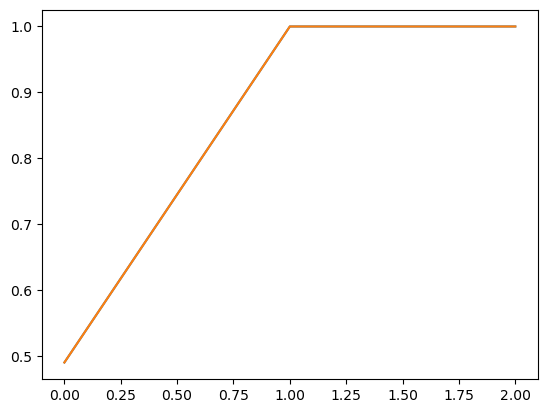

In [16]:
dfs = {result.path: result.metrics_dataframe for result in results}
# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.val_accuracy.plot(ax=ax, legend=False)

## Storing results

In [17]:
output_path = benchmark_config['output_dir']

# make sure that output_dir exists
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [18]:
# save general configs
export_as(default_config, os.path.join(output_path, "general_config.yaml"), save_type='yaml')

In [19]:
# save results dataframe
results.get_dataframe().to_csv(os.path.join(output_path, "results.csv"), index=None)

In [20]:
# for each trial save results
for result in results:
    # get metrics
    trial_metrics = result.metrics_dataframe

    # get trial id
    trial_id = trial_metrics.trial_id[0]

    # get config
    trial_config = result.config

    # saving
    trial_metrics.to_csv(os.path.join(output_path, f"{trial_id}.csv"), index=None)
    export_as(trial_config, os.path.join(output_path, f"{trial_id}.yaml"), save_type='yaml')